# Analysis of House Price Index Damage Functions

#### Independent Variables : Temperature, Precipitation and Sea Level Change
#### Dependent Variable: House Price Index

In [1]:
import pandas as pd
pd.set_option('display.precision', 4)
pd.set_option('display.max_rows', 99999)
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller as adf
from sklearn.metrics import r2_score
from sklearn import metrics
import math
import sklearn
import itertools
from statsmodels.stats.outliers_influence import variance_inflation_factor
#os.chdir(os.getcwd()[:-7] + '1. Input/2. Processed Data')
os.getcwd()

'/Users/yuqingwu/OneDrive - The University of Chicago/Winter 2022/WinterCodes/EY/2021'

### Data Transformation for dependent variables
    1. Raw Data
    2. Percentage change
    3. First difference
    4. Second difference

### Data Transformation for independent variables
    1. Raw Data
    2. First difference
    3. Second difference
    4. Percentage Change
    5. Raw*First difference
    6. Raw*Second difference 
    
    Based on all the data transformation we have above, we do squared and cube of them so we have 3*6 = 18 columns
    
    Again, we do lag 0.1.2 of the transformation we have. Then num of columns in the output dataframe is 18*3 = 54 columns. Lag1 implies today's House Price Index on yesterday's temperature. Lag2 implies today's House Price Index on temperature the day before yesterday.

In [2]:
def build_dependent_df(variable, transform = 'Percent Change', df = None):
    if df is None:
        df = pd.read_excel(variable+".xlsx")
        df['Year'] = pd.to_datetime(df['Year'],format='%Y')
        df['Year'] = pd.to_datetime(df['Year']).dt.to_period('Y')
        df = df.set_index('Year')
        df = df[['HPI']]
        
    new_df = pd.DataFrame(index = df.index)
    org_name = df.columns[0]
    if transform == 'Raw':
        new_df[org_name] = df[org_name]
    if transform == 'Percent Change':
        name = '% chg ' + org_name
        new_df[name] = df[org_name].pct_change()
    if transform == 'Delta':
        name = r' $\Delta$' + org_name
        new_df[name] = df[org_name].diff()
    if transform == 'Delta Square':
        name = r' $\Delta^2$' + org_name
        new_df[name] = df[org_name].diff().diff()
    return new_df


def build_independent_df(variable,yearly=False, df = None):
    if df is None:
        df = pd.read_csv(variable+'.csv', skiprows = 4)
        df['Date'] = pd.to_datetime(df['Date'],format='%Y%m')
        df['Date'] = pd.to_datetime(df['Date']).dt.to_period('M')
        df = df.drop(['Anomaly'], axis=1)
        df = df.set_index('Date')
        if yearly:
            df = df.resample('Y').mean()
        else:
            df = df.resample('Q').mean()
            
    df = df.rename(columns={"Value": variable})

    ########### Add log transformation ##############
    df[r'log'+variable] = np.log(df[variable])
    ########### Add exponential transformation ##############
    df[r'exp'+variable] = np.exp(df[variable])

    df[r'$\Delta$'+variable] = df[variable].diff()
    df[r'$\Delta^2$'+variable] = df[r'$\Delta$'+variable].diff()
    df[variable+r'*($\Delta)$'] = df[variable]*df[r'$\Delta$'+variable]
    df[variable+r'*($\Delta^2)$'] = df[variable]*df[r'$\Delta^2$'+variable]

    df_sqr = df**2
    col_names = df.columns
    for name in col_names:
        df_sqr = df_sqr.rename(columns={name:name+r'^2'})

    df_cube = df**3
    col_names = df.columns
    for name in col_names:
        df_cube = df_cube.rename(columns={name:name+r'^3'})
    df = pd.concat([df,df_sqr,df_cube], axis = 1)

    df_lag1 = df.shift()
    col_names = df.columns
    for name in col_names:
        df_lag1 = df_lag1.rename(columns={name:name+' lag1'})

    df_lag2 = df.shift(2)
    col_names = df.columns
    for name in col_names:
        df_lag2 = df_lag2.rename(columns={name:name+' lag2'})

    df = pd.concat([df,df_lag1,df_lag2], axis = 1)


    return df

In [3]:
def single_regression(dependent, independent, end = '2020', dummy=False):
    dependent = dependent.loc[:end]
    independent = independent.loc[:end]
    summary = pd.DataFrame(columns = ['R_squared', 'beta', 'p_value'])
    
    for dep in dependent.columns:
        lhs = dependent[dep]
        for indep in independent.columns:
            rhs = sm.add_constant(independent.loc[lhs.index, indep])
            if dummy:
                rhs['season'] = rhs.index
                rhs['season'] = rhs.index
                rhs['season'] = rhs['season'].astype(str)
                rhs['season'] = rhs['season'].str[-1:]
                dummies = pd.get_dummies(rhs['season'])
                rhs = pd.concat([rhs, dummies], axis = 1)
                rhs = rhs.drop(['season'], axis=1)
            res = sm.OLS(lhs, rhs, missing='drop').fit()
            R_squared = round(res.rsquared, 4)
            beta = round(res.params[1], 4)
            p_value = round(res.pvalues[1], 4)
            lhs_predict = res.predict(rhs)

            if len(lhs.dropna()) <= len(lhs_predict.dropna()):
                start_time = lhs.dropna().index[0]
                end_time = lhs.dropna().index[-1]
                lhs_predict = lhs_predict[str(start_time):str(end_time)] 
                mse = sklearn.metrics.mean_squared_error(lhs.dropna(), lhs_predict)
            else:
                start_time = lhs_predict.dropna().index[0]
                end_time = lhs_predict.dropna().index[-1]
                lhs_predict = lhs_predict[str(start_time):str(end_time)]  
                lhs_mse = lhs.dropna()[str(start_time):str(end_time)]
                mse = sklearn.metrics.mean_squared_error(lhs_mse, lhs_predict)
            
            summary.loc[dep + '_' + indep, 'R_squared'] = R_squared
            summary.loc[dep + '_' + indep, 'beta'] = beta
            summary.loc[dep + '_' + indep, 'p_value'] = p_value
            summary.loc[dep + '_' + indep, 'RMSE'] = math.sqrt(mse)
    
    return summary

## Single Variable: Feature Engineering and Feature Selection 

### House Price Index on Temperature

In [4]:
dep_var = 'HPI'
dep = build_dependent_df(dep_var)

In [5]:
from IPython.core.display_functions import display

# Yearly Data
ind = build_independent_df('Temp', yearly=True)
summary = single_regression(dep,ind)
summary = summary.sort_values(by=['R_squared', 'p_value'], ascending=False)

display(summary.head())
#columnNames = list(summary.head().index)
columnNames = list(summary.index)
var_list = [i.split('_')[1] for i in columnNames]
print('Top variable:', var_list)

,R_squared,beta,p_value,RMSE
% chg HPI_logTemp lag2,0.0354,-0.4454,0.2157,0.0455
% chg HPI_logTemp^2 lag2,0.0351,-0.0559,0.2176,0.0455
% chg HPI_logTemp^3 lag2,0.0349,-0.0094,0.2194,0.0455
% chg HPI_Temp lag2,0.0343,-0.0083,0.2231,0.0455
% chg HPI_Temp^2 lag2,0.0332,-0.0001,0.2308,0.0456


Top variable: ['logTemp lag2', 'logTemp^2 lag2', 'logTemp^3 lag2', 'Temp lag2', 'Temp^2 lag2', 'Temp^3 lag2', 'logTemp lag1', 'logTemp^2 lag1', 'logTemp^3 lag1', 'Temp lag1', 'Temp^2 lag1', 'Temp^3 lag1', 'logTemp', 'logTemp^3', 'logTemp^2', 'Temp', 'Temp^2', 'Temp^3', '$\\Delta^2$Temp^2 lag1', 'Temp*($\\Delta^2)$^2 lag1', 'Temp*($\\Delta)$^2', '$\\Delta^2$Temp^3 lag1', 'Temp*($\\Delta^2)$^3 lag1', '$\\Delta$Temp^2', 'Temp*($\\Delta)$^3 lag2', '$\\Delta$Temp^3 lag2', 'Temp*($\\Delta)$ lag2', '$\\Delta$Temp lag2', '$\\Delta^2$Temp^2 lag2', 'Temp*($\\Delta^2)$^2 lag2', 'Temp*($\\Delta)$^2 lag2', '$\\Delta$Temp^2 lag2', '$\\Delta$Temp lag1', 'Temp*($\\Delta)$ lag1', '$\\Delta$Temp^2 lag1', 'Temp*($\\Delta)$^2 lag1', 'Temp*($\\Delta^2)$^2', '$\\Delta^2$Temp^3 lag2', 'Temp*($\\Delta)$^3', 'Temp*($\\Delta^2)$ lag1', '$\\Delta^2$Temp lag1', '$\\Delta^2$Temp', '$\\Delta^2$Temp^3', '$\\Delta^2$Temp lag2', 'Temp*($\\Delta^2)$^3', '$\\Delta$Temp', 'Temp*($\\Delta^2)$', 'Temp*($\\Delta^2)$^3 lag2'

In [6]:
# Correlation among variables
tempdf = ind[var_list]
corrdf = dep.join(tempdf)
corrdf.corr()

,% chg HPI,logTemp lag2,logTemp^2 lag2,logTemp^3 lag2,Temp lag2,Temp^2 lag2,Temp^3 lag2,logTemp lag1,logTemp^2 lag1,logTemp^3 lag1,...,Temp*($\Delta)$,expTemp lag2,expTemp lag1,expTemp,expTemp^2 lag2,expTemp^2 lag1,expTemp^3 lag2,expTemp^3 lag1,expTemp^2,expTemp^3
% chg HPI,1.0000,-0.1882,-0.1874,-0.1867,-0.1852,-0.1823,-0.1793,-0.1536,-0.1529,-0.1522,...,0.0114,-0.0293,-0.0365,-0.1202,0.0413,-0.0116,0.0601,-0.0139,-0.1558,-0.1780
logTemp lag2,-0.1882,1.0000,1.0000,1.0000,0.9999,0.9997,0.9993,0.4747,0.4747,0.4746,...,-0.2748,0.8234,0.3620,0.1067,0.6080,0.2312,0.4957,0.1593,0.0566,0.0353
logTemp^2 lag2,-0.1874,1.0000,1.0000,1.0000,1.0000,0.9998,0.9995,0.4747,0.4747,0.4746,...,-0.2749,0.8250,0.3621,0.1063,0.6099,0.2312,0.4975,0.1591,0.0561,0.0349
logTemp^3 lag2,-0.1867,1.0000,1.0000,1.0000,1.0000,0.9998,0.9995,0.4747,0.4747,0.4746,...,-0.2750,0.8266,0.3622,0.1058,0.6118,0.2312,0.4994,0.1590,0.0556,0.0344
Temp lag2,-0.1852,0.9999,1.0000,1.0000,1.0000,0.9999,0.9997,0.4747,0.4746,0.4745,...,-0.2752,0.8297,0.3622,0.1049,0.6156,0.2311,0.5030,0.1587,0.0547,0.0335
Temp^2 lag2,-0.1823,0.9997,0.9998,0.9998,0.9999,1.0000,0.9999,0.4745,0.4745,0.4744,...,-0.2756,0.8359,0.3624,0.1030,0.6233,0.2309,0.5104,0.1581,0.0527,0.0317
Temp^3 lag2,-0.1793,0.9993,0.9995,0.9995,0.9997,0.9999,1.0000,0.4743,0.4742,0.4741,...,-0.2760,0.8421,0.3624,0.1011,0.6309,0.2307,0.5179,0.1575,0.0507,0.0298
logTemp lag1,-0.1536,0.4747,0.4747,0.4747,0.4747,0.4745,0.4743,1.0000,1.0000,1.0000,...,-0.5062,0.3421,0.8220,0.3471,0.1663,0.6069,0.0683,0.4951,0.2254,0.1565
logTemp^2 lag1,-0.1529,0.4747,0.4747,0.4747,0.4746,0.4745,0.4742,1.0000,1.0000,1.0000,...,-0.5063,0.3421,0.8236,0.3470,0.1663,0.6089,0.0682,0.4969,0.2253,0.1563
logTemp^3 lag1,-0.1522,0.4746,0.4746,0.4746,0.4745,0.4744,0.4741,1.0000,1.0000,1.0000,...,-0.5064,0.3422,0.8252,0.3470,0.1663,0.6108,0.0681,0.4988,0.2252,0.1562


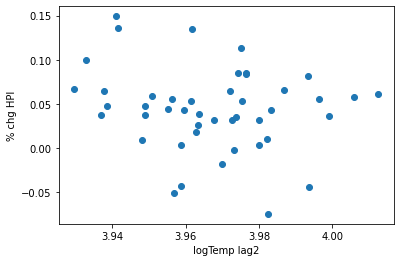

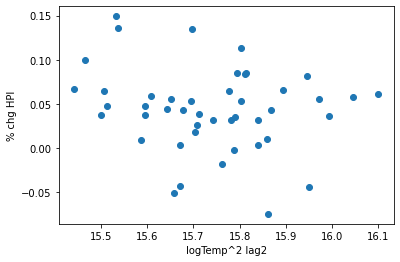

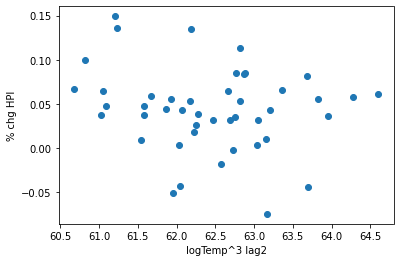

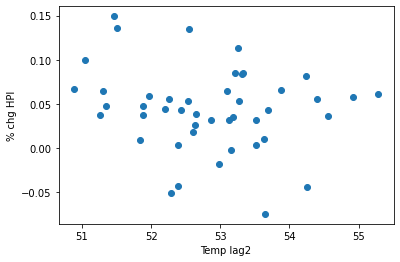

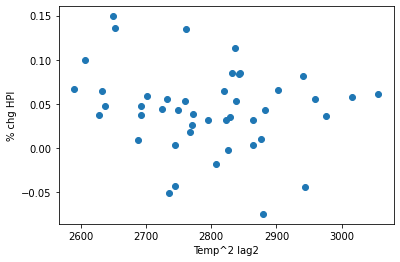

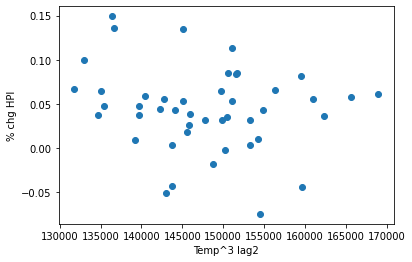

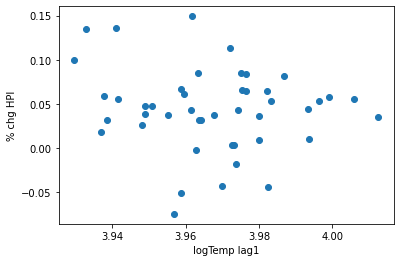

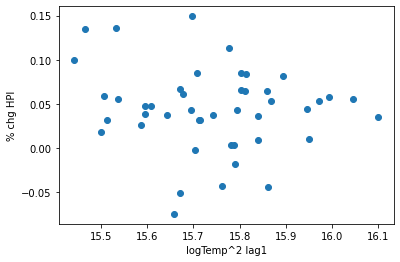

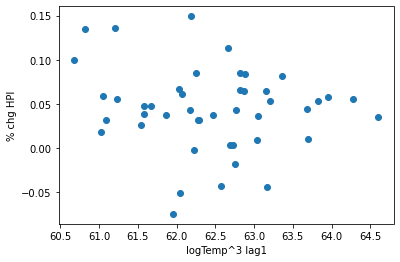

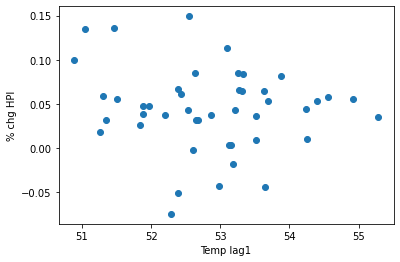

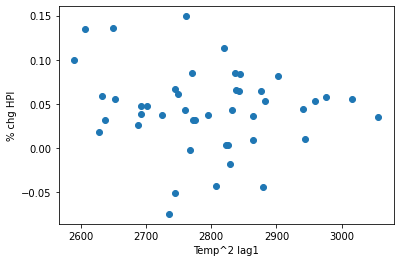

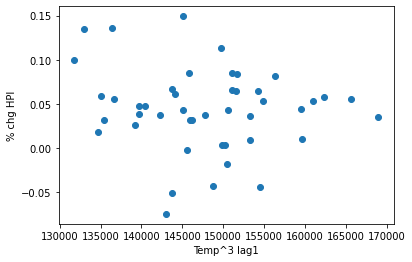

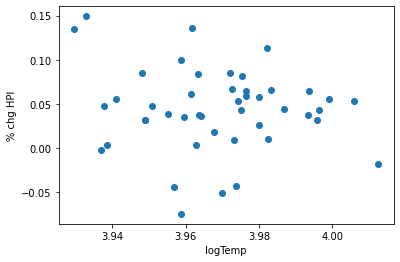

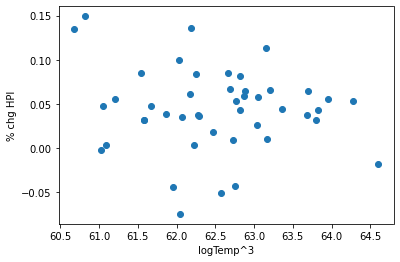

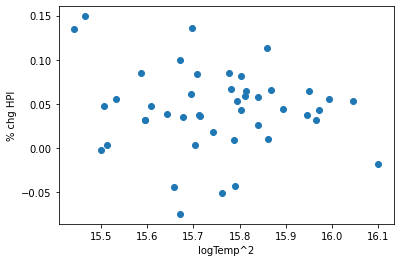

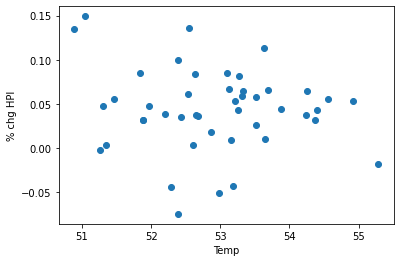

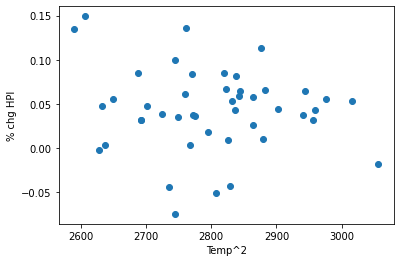

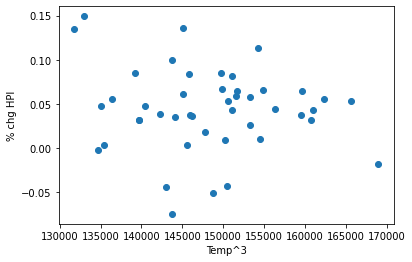

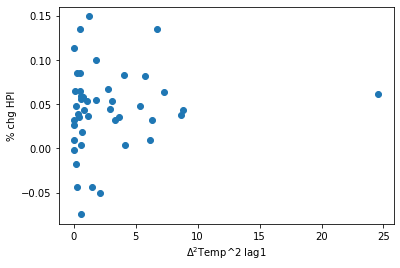

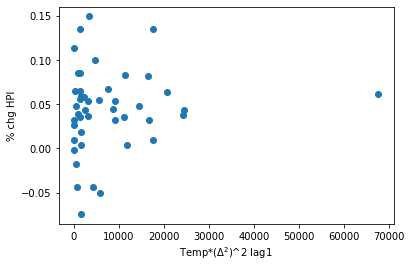

In [8]:
for i in range(20):
    plt.scatter(ind[var_list[i]]['1976':'2020'],dep['% chg '+dep_var]['1976':'2020'])
    plt.xlabel(var_list[i])
    plt.ylabel('% chg ' + dep_var)
    plt.show()

### House Price Index on Precipitation

In [12]:
# Yearly Data
ind = build_independent_df('Precipitation', yearly=True)
summary = single_regression(dep,ind)
summary = summary.sort_values(by=['R_squared', 'p_value'], ascending=False)

display(summary.head())
columnNames = list(summary.head().index)
var_list = [i.split('_')[1] for i in columnNames]
print('Top variable:', var_list)

,R_squared,beta,p_value,RMSE
% chg HPI_$\Delta^2$Precipitation^2 lag1,0.2613,0.1439,0.0003,0.0398
% chg HPI_Precipitation*($\Delta^2)$^2 lag1,0.244,0.023,0.0006,0.0403
% chg HPI_Precipitation*($\Delta^2)$^2,0.2079,0.0219,0.0016,0.0412
% chg HPI_$\Delta$Precipitation^2 lag1,0.2079,0.3575,0.0016,0.0412
% chg HPI_Precipitation*($\Delta^2)$^2 lag2,0.2001,0.0202,0.0021,0.0414


Top variable: ['$\\Delta^2$Precipitation^2 lag1', 'Precipitation*($\\Delta^2)$^2 lag1', 'Precipitation*($\\Delta^2)$^2', '$\\Delta$Precipitation^2 lag1', 'Precipitation*($\\Delta^2)$^2 lag2']


In [13]:
# Correlation among variables
tempdf = ind[var_list]
corrdf = dep.join(tempdf)
corrdf.corr()

,% chg HPI,$\Delta^2$Precipitation^2 lag1,Precipitation*($\Delta^2)$^2 lag1,Precipitation*($\Delta^2)$^2,$\Delta$Precipitation^2 lag1,Precipitation*($\Delta^2)$^2 lag2
% chg HPI,1.0000,0.5111,0.4940,0.4559,0.4560,0.4474
$\Delta^2$Precipitation^2 lag1,0.5111,1.0000,0.9876,0.4532,0.6973,0.3788
Precipitation*($\Delta^2)$^2 lag1,0.4940,0.9876,1.0000,0.4122,0.6216,0.3759
Precipitation*($\Delta^2)$^2,0.4559,0.4532,0.4122,1.0000,0.6866,0.1690
$\Delta$Precipitation^2 lag1,0.4560,0.6973,0.6216,0.6866,1.0000,0.1291
Precipitation*($\Delta^2)$^2 lag2,0.4474,0.3788,0.3759,0.1690,0.1291,1.0000


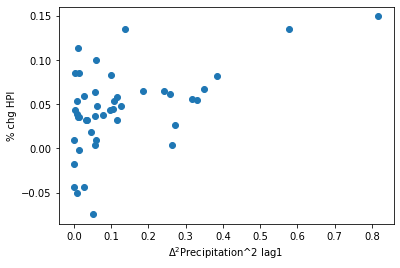

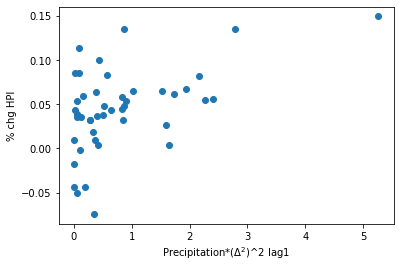

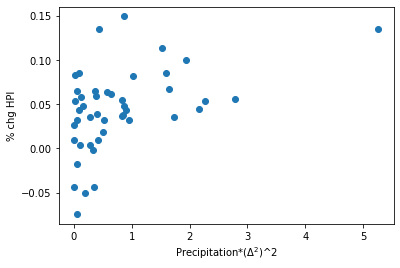

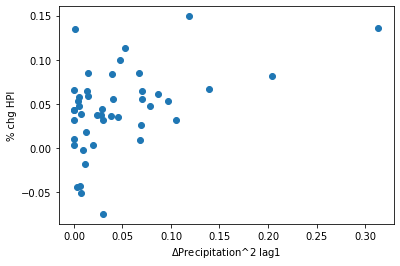

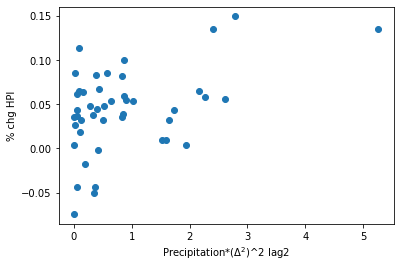

In [14]:
for i in range(5):
    plt.scatter(ind[var_list[i]]['1976':'2020'],dep['% chg '+dep_var]['1976':'2020'])
    plt.xlabel(var_list[i])
    plt.ylabel('% chg ' + dep_var)
    plt.show()

### House Price Index on Sea Level

In [15]:
# Yearly Data
df = pd.read_excel('Sea Level.xls').iloc[:, 0:2].set_index('Date')
df.columns = ['Value']
variable = 'Sea Level'
df = df.rename(columns={"Value": 'Sea Level'})

df_sqr = df**2
col_names = df.columns
for name in col_names:
    df_sqr = df_sqr.rename(columns={name:name+r'^2'})

df = pd.concat([df, df_sqr], axis = 1)

df_lag1 = df.shift()
col_names = df.columns
for name in col_names:
    df_lag1 = df_lag1.rename(columns={name:name+' lag1'})

df_lag2 = df.shift(2)
col_names = df.columns
for name in col_names:
    df_lag2 = df_lag2.rename(columns={name:name+' lag2'})

df = pd.concat([df,df_lag1,df_lag2], axis = 1)

########## using log transformation ###############
########## using exp transformation ###############

#df['log Sea Level'] = np.log(df['Sea Level'])
df['exp Sea Level'] = np.exp(df['Sea Level'])

df.index = df.index.to_period('Y')

In [16]:
# Yearly Data
dep = build_dependent_df(dep_var).iloc[:-1,:]
ind = df.loc[dep.index]
summary = single_regression(dep,ind)
summary = summary.sort_values(by=['R_squared', 'p_value'], ascending=False)

display(summary.head())
columnNames = list(summary.head().index)
var_list = [i.split('_')[1] for i in columnNames]
print('Top variable:', var_list)

,R_squared,beta,p_value,RMSE
% chg HPI_Sea Level lag2,0.0255,-0.0451,0.3007,0.0462
% chg HPI_Sea Level lag1,0.0134,-0.0348,0.4539,0.0465
% chg HPI_Sea Level^2,0.002,0.0419,0.7723,0.0468
% chg HPI_Sea Level^2 lag2,0.0019,0.0353,0.7805,0.0468
% chg HPI_Sea Level^2 lag1,0.0004,-0.0183,0.8999,0.0468


Top variable: ['Sea Level lag2', 'Sea Level lag1', 'Sea Level^2', 'Sea Level^2 lag2', 'Sea Level^2 lag1']


In [17]:
# Correlation among variables
tempdf = ind[var_list]
corrdf = dep.join(tempdf)
corrdf.corr()

,% chg HPI,Sea Level lag2,Sea Level lag1,Sea Level^2,Sea Level^2 lag2,Sea Level^2 lag1
% chg HPI,1.0000,-0.1596,-0.1159,0.0449,0.0432,-0.0195
Sea Level lag2,-0.1596,1.0000,-0.2745,0.0382,0.4523,-0.2202
Sea Level lag1,-0.1159,-0.2745,1.0000,-0.0931,-0.2002,0.4849
Sea Level^2,0.0449,0.0382,-0.0931,1.0000,0.1213,-0.0242
Sea Level^2 lag2,0.0432,0.4523,-0.2002,0.1213,1.0000,0.0081
Sea Level^2 lag1,-0.0195,-0.2202,0.4849,-0.0242,0.0081,1.0000


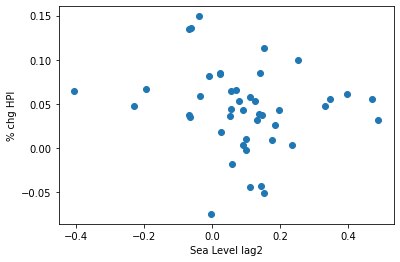

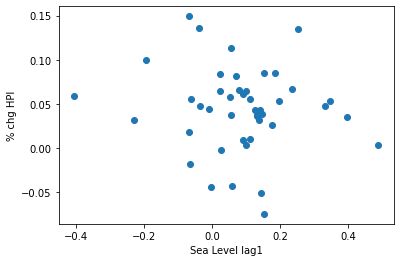

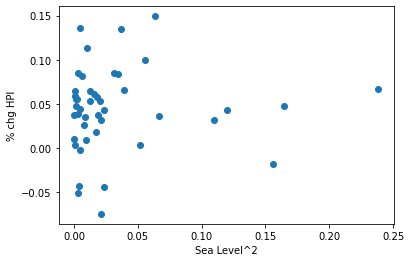

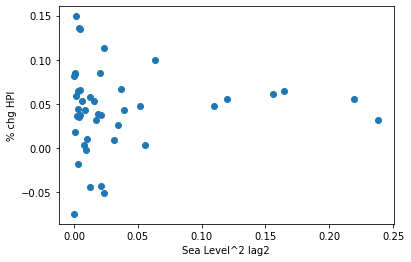

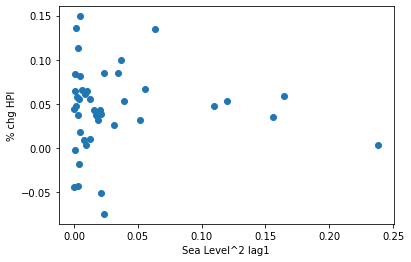

In [18]:
for i in range(5):
    plt.scatter(ind[var_list[i]]['1970':'2020'],dep['% chg '+dep_var]['1970':'2020'])
    plt.xlabel(var_list[i])
    plt.ylabel('% chg ' + dep_var)
    plt.show()

## Multi - Regression Model

In [15]:
dep = build_dependent_df(dep_var)
ind = build_independent_df('Precipitation', yearly=True)
Precip = pd.DataFrame(ind[['$\\Delta^2$Precipitation^2 lag1', 'Precipitation*($\\Delta^2)$^2']])
data = pd.concat([dep, Precip], axis = 1).dropna().reset_index()
data.columns = ['Date', dep_var+'_pct_change', 'Sec_Precip_Change_Sq_Lag1', 'Precip*Sec_Chg_Sq']

In [16]:
def multi_regression(independent, dependent): 
    summary = pd.DataFrame()
    independent_w_constant = sm.add_constant(independent)
    res = sm.OLS(dependent, independent_w_constant, missing='drop').fit()
    r_squared = round(res.rsquared, 4)
    adj_r_squared = round(res.rsquared_adj, 4)
    summary = pd.DataFrame(res.params[1:], columns = dependent.columns)
    summary.loc['R_squared'] = r_squared
    summary.loc['adj_R_suqared'] = adj_r_squared
    summary.loc['AIC'] = res.aic
    cols = ['VIF_'] + independent.columns
    
    
    if len(independent.columns) > 1:
        for i in range(len(independent.columns)):
            summary.loc['VIF_' + independent.columns[i]] = variance_inflation_factor(independent.values, i)

        display(independent.corr())
        
    plt.scatter(dependent, res.predict(independent_w_constant))
    plt.xlabel('Prediction')
    plt.ylabel('Actual Value')
    plt.show()
    
    
    return summary

Imports_pct_change on ['Sec_Precip_Change_Sq_Lag1']


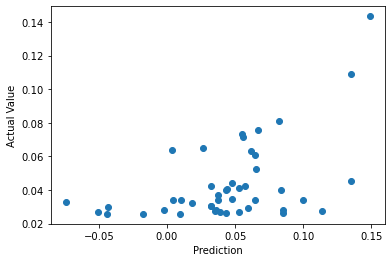

,HPI_pct_change
Sec_Precip_Change_Sq_Lag1,0.1439
R_squared,0.2613
adj_R_suqared,0.2441
AIC,-158.3877



Imports_pct_change on ['Precip*Sec_Chg_Sq']


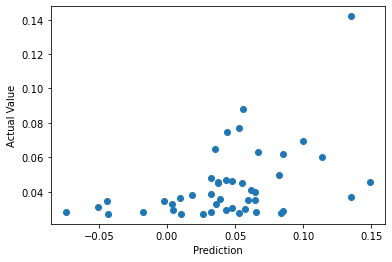

,HPI_pct_change
Precip*Sec_Chg_Sq,0.0219
R_squared,0.2079
adj_R_suqared,0.1895
AIC,-155.2486



Imports_pct_change on ['Sec_Precip_Change_Sq_Lag1', 'Precip*Sec_Chg_Sq']


,Sec_Precip_Change_Sq_Lag1,Precip*Sec_Chg_Sq
Sec_Precip_Change_Sq_Lag1,1.0000,0.4196
Precip*Sec_Chg_Sq,0.4196,1.0000


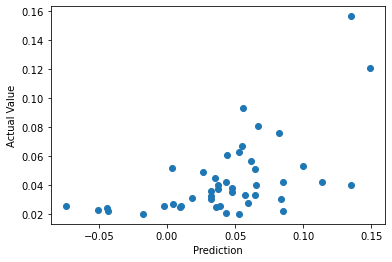

,HPI_pct_change
Sec_Precip_Change_Sq_Lag1,0.1093
Precip*Sec_Chg_Sq,0.0140
R_squared,0.3320
adj_R_suqared,0.3002
AIC,-160.9194
VIF_Sec_Precip_Change_Sq_Lag1,1.6872
VIF_Precip*Sec_Chg_Sq,1.6872


In [17]:
ind_list = ['Sec_Precip_Change_Sq_Lag1', 'Precip*Sec_Chg_Sq']
for L in range(1, len(ind_list)+1):
    for subset in itertools.combinations(ind_list, L):
        ind_subset = list(subset)
        print('Imports_pct_change on', ind_subset)
        display(multi_regression(data.loc[:, ind_subset], data.loc[:, ['HPI_pct_change']]))
        print()
